In [1]:
import os
#import cv2
import numpy as np
#from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras import models
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import confusion_matrix ,plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

epocs= 50

## Let's Get some data!

So we started by just getting the fashion mnist dataset. Tensorflow had this build it, so it was very conveniet. Because the autoencoder takes in the training images as the label and the input the training labels were only needed for the final 2-D mapping. 

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))
#test_labels = np.asarray(test_labels).astype('float32').reshape((-1,1))

## Make Noisy images now
* https://keras.io/examples/vision/autoencoder/

These functions I took directly from the Keras Site. It just displays the images and it also
adds noice to the image. I did change the type of noise however, and I was sure to give
it 0 mean gaussian noise.

In [3]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    mean = 0.0   # some constant
    std = 1.0    # some constant (standard deviation)
    noisy_array = array + np.random.normal(mean, std, array.shape)

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [4]:
train_images = train_images.astype('float32')/255.
test_images = test_images.astype('float32')/255.

noisy_train_data = noise(train_images)
noisy_test_data = noise(test_images)

## Build Model
Thd middle of the autoencoder was definitely the most difficult part. If I didn't get
the sizes right, I ended up with an output image that was not ($28 \times 28$) and my
final error check would fail. Thought it's not 100% symmetric, it does line the final
shape up very well.

The loss, stayed relatively close. It dropped initally and then stayed around ~0.39. With more training though my results would sometimes be better, other times, I would end up with just a white square.

In [5]:
input_img = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
bottleNeckOut = layers.Flatten(input_shape=x.shape)(encoded)
#bottleNeckOut = layers.Dense(4, activation='relu')(bottleNeckOut)
bottleNeckOut = layers.Dense(2, activation='relu')(bottleNeckOut)


bottleNeckIn = layers.Dense(4, activation='relu')(bottleNeckOut)
bottleNeckIn = layers.Reshape((2,2,1))(bottleNeckIn)

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(bottleNeckIn)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
denoiser = keras.models.clone_model(autoencoder)
encoder = keras.Model(input_img, bottleNeckOut)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
denoiser.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [6]:

history = autoencoder.fit(train_images, train_images, 
                          batch_size=64,
                          steps_per_epoch = 500,
                          shuffle = True,
                          epochs=epocs)

Epoch 1/50
500/500 [==============================] - 11s 21ms/step - loss: 0.5247 - accuracy: 0.4878
Epoch 2/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3830 - accuracy: 0.4882
Epoch 3/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3682 - accuracy: 0.4900
Epoch 4/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3577 - accuracy: 0.4938
Epoch 5/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3506 - accuracy: 0.4954
Epoch 6/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3497 - accuracy: 0.4941
Epoch 7/50
500/500 [==============================] - 11s 22ms/step - loss: 0.3486 - accuracy: 0.4927
Epoch 8/50
500/500 [==============================] - 11s 22ms/step - loss: 0.3447 - accuracy: 0.4970
Epoch 9/50
500/500 [==============================] - 11s 21ms/step - loss: 0.3438 - accuracy: 0.4971
Epoch 10/50
500/500 [==============================] - 11s 22ms/step - loss: 0.344

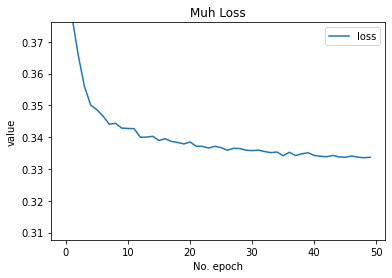

In [7]:
rebuild = autoencoder.predict(test_images)
avee = sum(history.history['loss'])/len(history.history['loss'])
plt.plot(history.history['loss'],label = "loss")
plt.title('Muh Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.ylim(avee-(avee*.10),avee+(avee*.10))
plt.legend(loc="upper right")
plt.show()

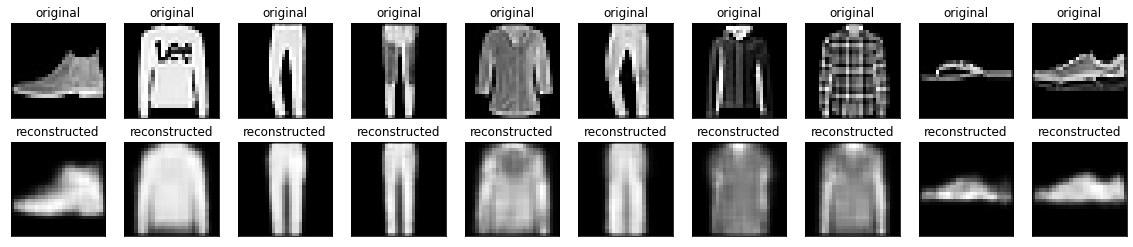

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(rebuild[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# De-noise
* https://keras.io/examples/vision/autoencoder/

My denoiser thinks everything looks like a shirt. I assume this is because shirts are rectangular and take up most of
the image size. This is similar to what the noise looks like on the picture. If I use a different kind of noise, or less
than a standard deviation of 1, my images come out a lot better. But I was trying to follow the instructions as stated.

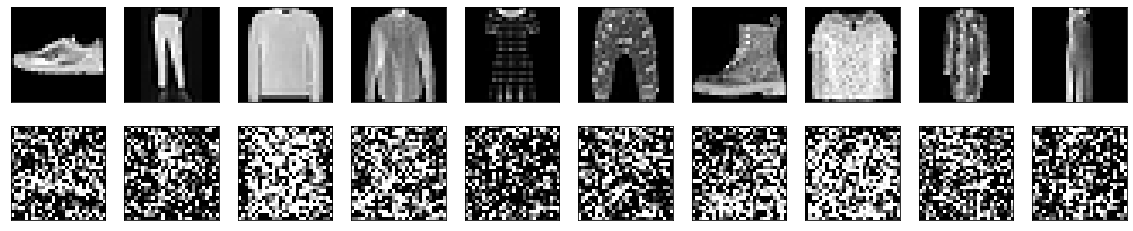

In [9]:
display(train_images, noisy_train_data)

In [10]:
history = denoiser.fit(noisy_train_data, train_images,
                          batch_size=64,
                          steps_per_epoch = 500,
                          shuffle = True,
                          epochs=epocs)

Epoch 1/50
500/500 [==============================] - 11s 22ms/step - loss: 0.5842 - accuracy: 0.4910
Epoch 2/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4960 - accuracy: 0.4834
Epoch 3/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4942 - accuracy: 0.4853
Epoch 4/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4930 - accuracy: 0.4858
Epoch 5/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4918 - accuracy: 0.4875
Epoch 6/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4920 - accuracy: 0.4866
Epoch 7/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4921 - accuracy: 0.4864
Epoch 8/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4910 - accuracy: 0.4877
Epoch 9/50
500/500 [==============================] - 11s 22ms/step - loss: 0.4922 - accuracy: 0.4875
Epoch 10/50
500/500 [==============================] - 11s 22ms/step - loss: 0.491

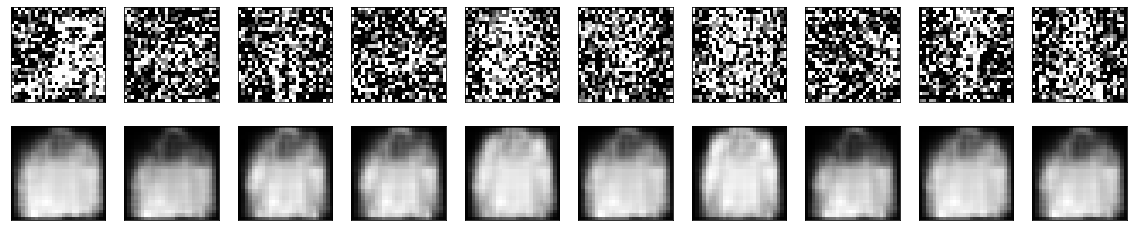

In [11]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# 2-D Plot

The 2-D plot didn't always come out nice. There's definitely some randomness to the 2-D plot. I realize that sometimes I
get a nice shape that is more similar to the PCA, but other times, it will be very far off.

(10000, 2)


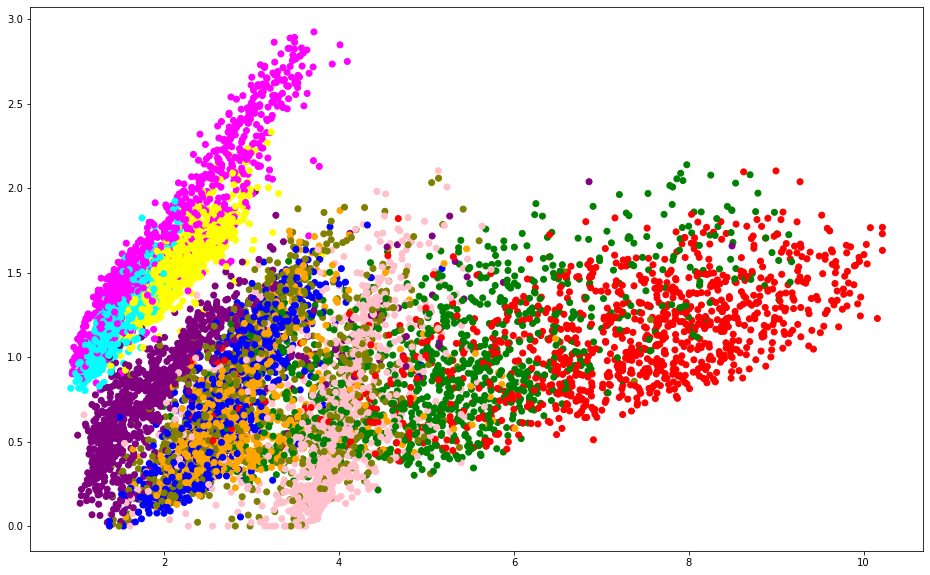

In [13]:
cdict = {0: 'pink',1: 'red', 2: 'blue', 3: 'green',4: 'orange', 5: 'magenta', 6: 'olive',
         7: 'cyan', 8: 'purple', 9: 'yellow'}
color_list = [cdict[i] for i in test_labels ]
x_test_encoded = encoder.predict(test_images, batch_size=32)
print(x_test_encoded.shape)
plt.figure(figsize=(16, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = color_list)
plt.show()

# PCA
For the PCA portion. I didn't understand what Dr. Rhodes meant by "using a for loop", so I
instead just did this in the same way that've used PCA in my last classes. I transformed the
 data from 3 dimensions to 2 before I fed it into the PCA function. In otherwords, I just
 vectorized the images using reshape. In this way I could reduce the components down to just
 two parameters(2 columns) and make the 2-D graph from that.

The shape of the PCA and the autoencoder is not always the same, but it is similar. There's definitely an overall shape that comes up when this is trained. I assume with more training the autoencoder and PCA 2-D maps would look more similar. But I was having an issue with consistentcy in my autoencoder.

In [14]:
pca = PCA(n_components=2)
ti = test_images.reshape(10000,-1)
principalComponents = pca.fit_transform(ti)
principalComponents.shape

(10000, 2)

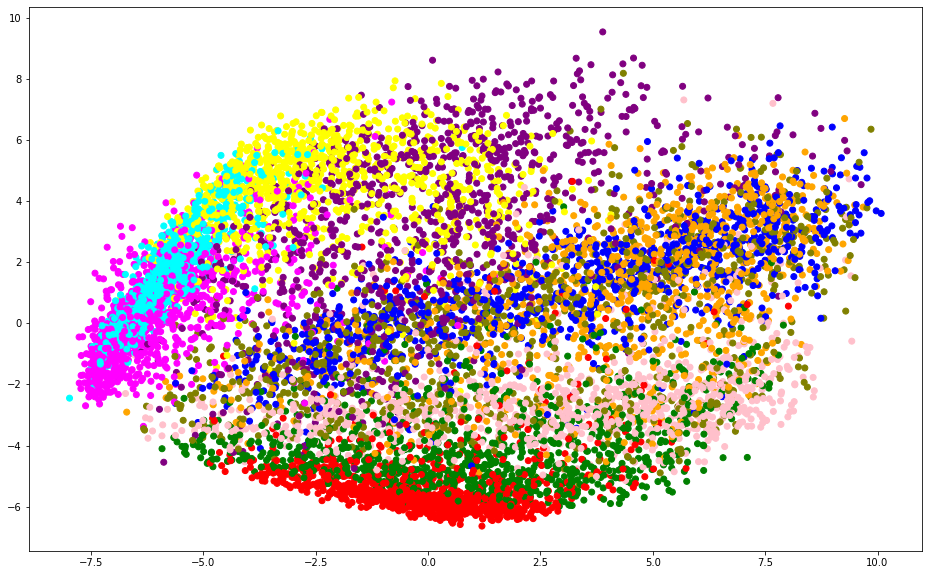

In [15]:
m,n = principalComponents.shape
plt.figure(figsize=(16, 10))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c = color_list[:m])
plt.show()